In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython import display

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
# Prepare data
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Step 1: Define Features & Configure Feature Columns
---

In [3]:
# Input feature --> total_rooms
feat_total_rooms = california_housing_dataframe[["total_rooms"]]

# Configure an empty numeric feature column in tf
col_feats = [tf.feature_column.numeric_column("total_rooms")]

feat_total_rooms.describe()

,total_rooms
count,17000.0
mean,2643.7
std,2179.9
min,2.0
25%,1462.0
50%,2127.0
75%,3151.2
max,37937.0


### Step 2: Define the target
---

In [4]:
# Target --> median_housing_value
target_house_val = california_housing_dataframe["median_house_value"]
target_house_val.describe()

count   17000.0
mean      207.3
std       116.0
min        15.0
25%       119.4
50%       180.4
75%       265.0
max       500.0
Name: median_house_value, dtype: float64

### Step 3: Configure the LinearRegressor
---

In [6]:
# We're building a linear regression model using Mini-Batch Stochastic 
# Gradient Descent (SGD)
# 
# The GradientDescentOptimizer is the "optimizer" for training our model, 
# with learning rate being the gradient "step"

# We apply gradient clipping to ensure the magnitude of gradients don't 
# become too large
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

# Use the optimizer to configure the LinearRegressor
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=col_feats,
    optimizer=optimizer
)

### Step 4: Define the input function
---

In [7]:
from mlcclib import preprocess
help(preprocess)

Help on function preprocess in module mlcclib.preprocess:

preprocess(features, targets, batch_sz=1, shuffle=True, num_epochs=None)
    :param features: pandas df of features
    :param targets: pandas df of targets
    :param batch_sz: Size of batches passed to the model
    :param shuffle: Whether to shuffle the data
    :param num_epochs: Repeat count; None = indefinitely
    :return: tuple of (features, labels) for the next data batch



### Step 5: Train the model
---

In [9]:
# Start with training for 100 steps
void = linear_regressor.train(
    input_fn=lambda: preprocess(feat_total_rooms, target_house_val),
    steps=100
)

### Step 6: Evaluate the model
---

In [10]:
# Create an input function for predictions
prediction_preprocess = lambda: preprocess(
    feat_total_rooms, 
    target_house_val, 
    num_epochs=1, 
    shuffle=False
)

# Use the linear regressor to make predictions
predictions = linear_regressor.predict(input_fn=prediction_preprocess)
predictions = np.array([item["predictions"][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, target_house_val)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56308.999
Root Mean Squared Error (on training data): 237.295


In [11]:
print(predictions)
print(np.array(target_house_val))

[0.34159538 0.151298   0.22969693 ... 0.12599835 0.1949974  0.1370982 ]
[324.6 252.8 239.7 ... 346.7  82.3 187.1]


In [12]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.295


Our model is pretty bad, with error spanning half the range of the target values

### Step 6: Reduce model error
---

In [13]:
# How well do our predictions match our targets?
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(target_house_val)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.3,207.3
std,0.2,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.2,180.4
75%,0.3,265.0
max,3.8,500.0


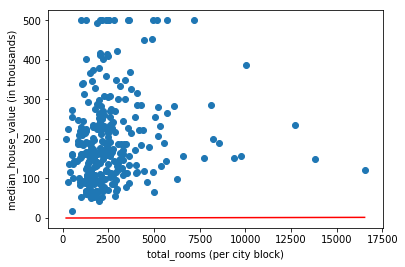

In [14]:
def plot(linear_regressor):
    # Plot the data sets
    sample = california_housing_dataframe.sample(n=300)
    x_0 = sample["total_rooms"].min()
    x_1 = sample["total_rooms"].max()
    
    # Retrieve the final weight and bias that our model came up with during training
    weight = linear_regressor.get_variable_value("linear/linear_model/total_rooms/weights")[0]
    bias = linear_regressor.get_variable_value("linear/linear_model/bias_weights")
    
    # mx + b, we're fitting a line
    y_0 = weight * x_0 + bias
    y_1 = weight * x_1 + bias
    
    plt.plot([x_0, x_1], [y_0, y_1], c="red")
    plt.scatter(sample["total_rooms"], sample["median_house_value"])
    plt.ylabel("median_house_value (in thousands)")
    plt.xlabel("total_rooms (per city block)")
    
    plt.show()
    
    
plot(linear_regressor)

It's god-awful

### Task 1: Achieve an RMSE of 180 or below

In [16]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """
    :param learning_rate: float: the learning rate 
    :param steps: int: total number of training steps (each step is a fwd-bckwd 
        pass over a single batch)
    :param batch_size: int: the batch size
    :param input_feature: string: a column from 'california_hosing_dataframe' to use as an input feature
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    input_feature_data = california_housing_dataframe[[input_feature]]  # (x)
    target_label = "median_house_value"                                 # (y)
    targets = california_housing_dataframe[target_label]                # (y-label)
    
    # Create column for the input feature
    feature_column = [tf.feature_column.numeric_column(input_feature)]
    
    # Create the input (preprocessing) functions
    training_preprocessor = lambda: preprocess(
        input_feature_data, 
        targets, 
        batch_sz=batch_size
    )
    
    prediction_preprocessor = lambda: preprocess(
        input_feature_data, 
        targets, 
        num_epochs=1, 
        shuffle=False
    )
    
    # Create the linear regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_column,
        optimizer=optimizer
    )
    
    # Plot during each period
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line By Period")
    plt.ylabel(target_label)
    plt.xlabel(input_feature)
    
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[input_feature], sample[target_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model in a loop, periodically assessing loss metrics
    print("RMSE (on training data):")
    root_mean_squared_errors = list()
    
    for period in range(0, periods):
        # Train the model w/ the previous model as input
        linear_regressor.train(
            input_fn=training_preprocessor,
            steps=steps_per_period
        )
        
        # Compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_preprocessor)
        predictions = np.array([item["predictions"][0] for item in predictions])
        
        # Compute loss
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets)
        )
        
        # Print the current loss
        print("Period: %02d\tLoss: %0.2f" % (period, root_mean_squared_error))
        
        # Add the loss metric for the current period to our list
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Track the weights / biases (hyperparams)
        weight = linear_regressor.get_variable_value("linear/linear_model/%s/weights" % input_feature)[0]
        bias = linear_regressor.get_variable_value("linear/linear_model/bias_weights")
        
        # Get the graph extents
        y_extents = np.array([0, sample[target_label].max()])
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(
            np.minimum(x_extents, sample[input_feature].max()), 
            sample[target_label].min()
        )
        y_extents = weight * x_extents + bias
        
        # Plot each training iteration
        plt.plot(x_extents, y_extents, color=colors[period])
    
    # Output a graph of the loss metrics with respect to time
    plt.subplot(1, 2, 2)
    plt.ylabel("RMSE")
    plt.xlabel("Period")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RSME (on training data): %0.2f" % root_mean_squared_error)

RMSE (on training data):


Period: 00	Loss: 225.63


Period: 01	Loss: 214.42


Period: 02	Loss: 204.04


Period: 03	Loss: 194.62


Period: 04	Loss: 186.29


Period: 05	Loss: 181.89


Period: 06	Loss: 176.79


Period: 07	Loss: 171.74


Period: 08	Loss: 168.84


Period: 09	Loss: 167.37


,predictions,targets
count,17000.0,17000.0
mean,116.3,207.3
std,95.9,116.0
min,0.1,15.0
25%,64.3,119.4
50%,93.6,180.4
75%,138.7,265.0
max,1669.2,500.0


Final RSME (on training data): 167.37


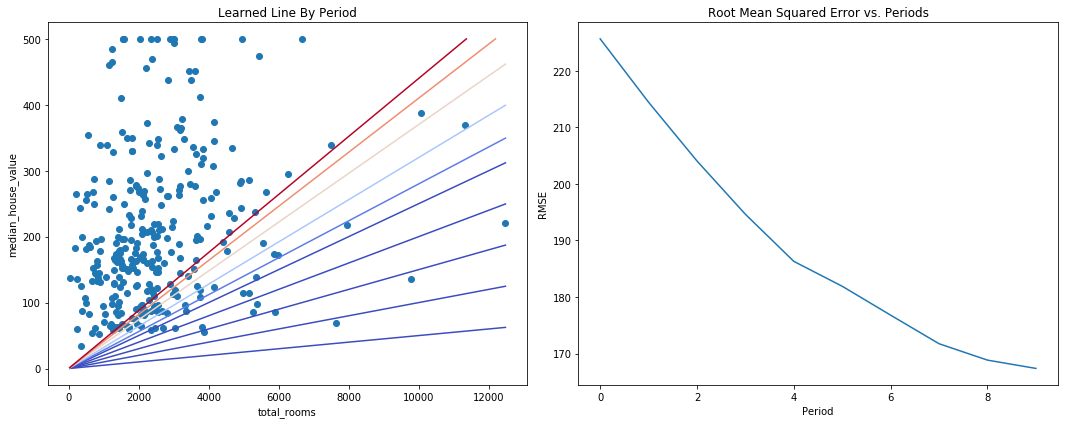

In [17]:
learning_rate = 0.0001
steps = 100
batch_size = 1

train_model(learning_rate, steps, batch_size)

In [ ]:
### Task 2: Try a different feature

